### Adicionando as bibliotecas necessárias:

## Bibliotecas utilizadas

In [1]:
import requests
import json
import matplotlib.pyplot as plt
import pandas as pd
from typing import Dict, Any

## url da API utilizada e define que os dados serão em json (por padrão estava xml)

In [2]:
# URL da API
url = "https://legis.senado.leg.br"

# define os cabeçalhos para aceitar a resposta em JSON
headers = {
    "Accept": "application/json"
}

## Criação da classe Senador que será preenchido pelos senadores atuais

In [3]:
class Senador:
    def __init__(self, codigo: str, nome: str, sexo: str, partido: str, uf: str, 
                 email: str, url_foto: str, url_pagina: str) -> None:
        self.codigo: str = codigo
        self.nome: str = nome
        self.sexo: str = sexo
        self.partido: str = partido
        self.uf: str = uf
        self.email: str = email
        self.url_foto: str = url_foto
        self.url_pagina: str = url_pagina

    @classmethod
    def from_json(cls, data: Dict[str, Any]) -> 'Senador':
        identificacao = data['IdentificacaoParlamentar']
        return cls(
            codigo=identificacao.get('CodigoParlamentar', ''),
            nome=identificacao.get('NomeParlamentar', ''),
            sexo=identificacao.get('SexoParlamentar', ''),
            partido=identificacao.get('SiglaPartidoParlamentar', ''),
            uf=identificacao.get('UfParlamentar', ''),
            email=identificacao.get('EmailParlamentar', ''),
            url_foto=identificacao.get('UrlFotoParlamentar', ''),
            url_pagina=identificacao.get('UrlPaginaParlamentar', '')
        )

    def to_dict(self) -> Dict[str, str]:
        return {
            'Código': self.codigo,
            'Nome': self.nome,
            'Sexo': self.sexo,
            'Partido': self.partido,
            'UF': self.uf,
            'Email': self.email,
            'URL Foto': self.url_foto,
            'URL Página': self.url_pagina
        }

## * Função 'obter_senadores_atuais': recebe o json com os senadores atuais e preenche na classe 'Senador'
## * Função 'obter_df_senadores_atuais': Utiliza a função 'to_dict' da classe 'Senador' para transformar as informações da classe em um dicionário, e depois converte o dicionário em um dataframe utilizando Pandas

In [4]:
def obter_senadores_atuais():
    url = 'https://legis.senado.leg.br/dadosabertos/senador/lista/atual'
    
    response = requests.get(url, headers=headers)
    
    data = response.json()
    
    # Acessando a estrutura correta dentro do JSON
    lista_parlamentares = data.get('ListaParlamentarEmExercicio', {}).get('Parlamentares', {})

    senadores = []
    for parlamentar in lista_parlamentares.get('Parlamentar', []):
        senador = Senador.from_json(parlamentar)
        senadores.append(senador)
    
    return senadores


def obter_df_senadores_atuais(senadores):
    # converte a lista de senador para dataframe
    senadores_dict = [senador.to_dict() for senador in senadores]
    df = pd.DataFrame(senadores_dict)
    
    return df

## Preenche a classe Senador e obtém o dataframe dos dados dos senadores

In [5]:
senadores_atuais = obter_senadores_atuais()
    
df_senadores_atuais = obter_df_senadores_atuais(senadores_atuais)

## Plota um gráfico em pizza da porcentagem de senadores atuais que são homens e mulheres, é importante para destacar a disparidade de homens no senado e a necessidade de mudar essa realidade

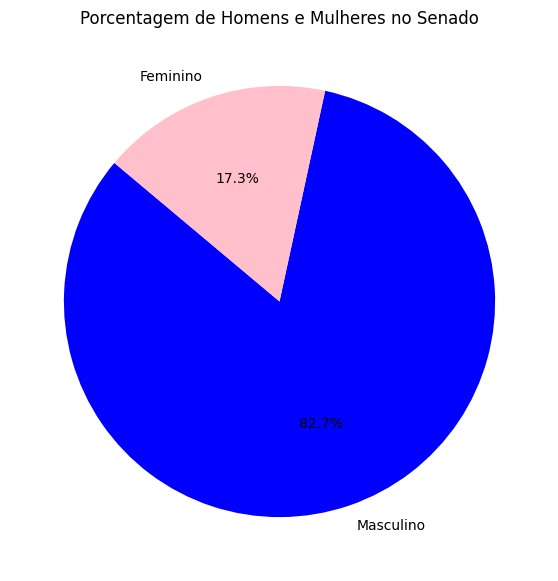

In [6]:
def calcular_porcentagem_genero(df):
    total_senadores = len(df)
    
    # conta a quantidade de senadores por genero
    contagem_genero = df['Sexo'].value_counts()
    
    # inicializa um dicionário para armazenar a porcentagem
    porcentagem_genero = {}
    
    for genero, contagem in contagem_genero.items():
        porcentagem = (contagem / total_senadores) * 100
        porcentagem_genero[genero] = porcentagem
        
    return porcentagem_genero

def plotar_grafico_pizza(porcentagem_genero):
    labels = porcentagem_genero.keys()
    sizes = porcentagem_genero.values()
    colors = ['blue', 'pink']

    plt.figure(figsize=(7, 7))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.title("Porcentagem de Homens e Mulheres no Senado")
    plt.show()
    
porcentagem_genero = calcular_porcentagem_genero(df_senadores_atuais)

plotar_grafico_pizza(porcentagem_genero)

## Plota um gráfico em barra da distribuição dos senadores atuais por partido, destacando se há um equilíbrio ou não dos partidos no senado

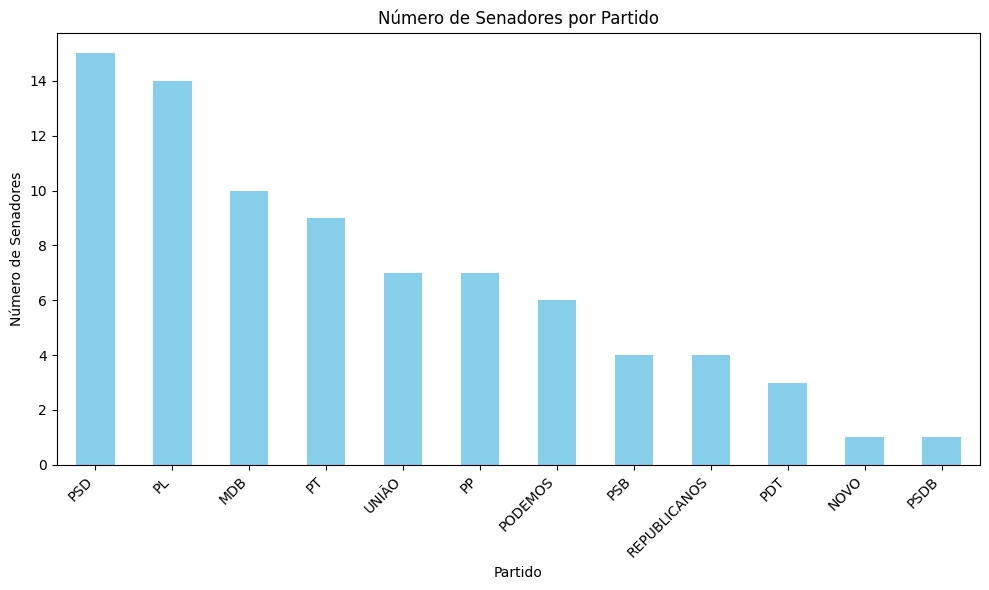

In [7]:
def plotar_senadores_por_partido(df):
    # conta a quantidade de senadores por partido
    contagem_partidos = df['Partido'].value_counts()
    
    # cria o grafico de barras
    plt.figure(figsize=(10, 6))
    contagem_partidos.plot(kind='bar', color='skyblue')
    
    # adiciona título e rótulos aos eixos
    plt.title('Número de Senadores por Partido')
    plt.xlabel('Partido')
    plt.ylabel('Número de Senadores')
    
    # rotaciona os rotulos do eixo x para melhor leitura
    plt.xticks(rotation=45, ha='right')
    
    # Exibir o grafico
    plt.tight_layout()
    plt.show()
    
plotar_senadores_por_partido(df_senadores_atuais)

## Gera uma lista ordenada de forma decrescente do número de matérias de autoria principal de cada senador no ano de 2024. Essa tabela é importante para verificar os senadores que são mais atuantes com propostas próprias, ou seja, os que mais se dedicam

In [8]:
def obter_autorias(codigo, ano=2024):
    url = f'https://legis.senado.leg.br/dadosabertos/senador/{codigo}/autorias'
    params = {'ano': ano}
    
    response = requests.get(url, params=params, headers=headers)
    
    data = response.json()
    
    autorias = data.get('MateriasAutoriaParlamentar', {}).get('Parlamentar', {}).get('Autorias', {}).get('Autoria', [])
    
    # inicializa a contagem
    contador = 0
    
    # itera sobre cada autoria
    for autoria in autorias:
        if autoria.get('IndicadorAutorPrincipal') == "Sim":
            contador += 1
    
    # retorna o total de autorias principais
    return contador

def exibir_tabela_autorias_principais(df):
    # adiciona coluna com o número de autorias principais
    df['NumeroAutoriasPrincipais'] = df['Código'].apply(lambda codigo: obter_autorias(codigo))
    
    # ordena o dataframe pelo número de autorias principais em ordem decrescente
    df_sorted = df.sort_values(by='NumeroAutoriasPrincipais', ascending=False)
    
    # seleciona apenas as colunas necessárias
    tabela = df_sorted[['Código', 'Nome', 'NumeroAutoriasPrincipais']]
    
    # exibe a tabela
    print(tabela.to_string(index=False))
    
exibir_tabela_autorias_principais(df_senadores_atuais)

Código                      Nome  NumeroAutoriasPrincipais
  6335             Damares Alves                       109
  5352          Rogério Carvalho                       109
  5936           Carlos Portinho                        92
  5976             Eduardo Girão                        90
  3806          Zequinha Marinho                        81
   825                Paulo Paim                        71
  5985             Nelsinho Trad                        63
  4770              Izalci Lucas                        59
  6009  Astronauta Marcos Pontes                        55
  5982         Alessandro Vieira                        52
   345               Flávio Arns                        52
  5895              Jorge Kajuru                        52
  4811          Laércio Oliveira                        50
  5008            Humberto Costa                        47
  6027           Mecias de Jesus                        43
  6338             Teresa Leitão                        

## Plota um gráfico em pizza da porcentagem de senadores atuais que possuem ensino superior. Significando, pelo menos na teoria quem tem maior preparo para atuar no cargo

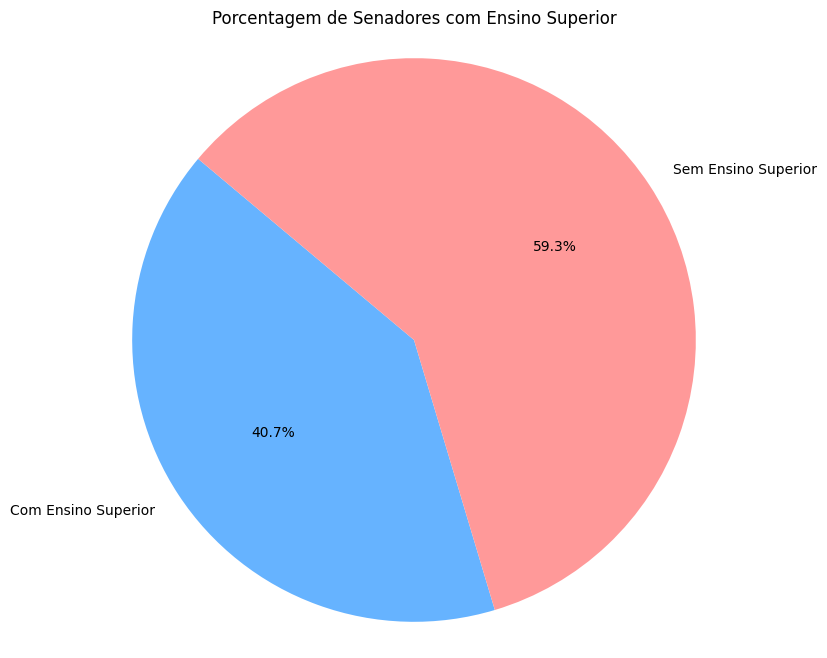

In [9]:
def obter_historico_academico(codigo):
    url = f'https://legis.senado.leg.br/dadosabertos/senador/{codigo}/historicoAcademico'
    
    response = requests.get(url, headers=headers)
    
    data = response.json()
    
    # Verifica se o campo "HistoricoAcademico" está presente, retornando TRUE se estiver presente e FALSE caso contrário
    return 'HistoricoAcademico' in data.get('HistoricoAcademicoParlamentar', {}).get('Parlamentar', {})

def calcular_porcentagem_ensino_superior(df):
    total_senadores = len(df)
    
    # cria a coluna 'EnsinoSuperior' e armazena se tem ou não
    df['EnsinoSuperior'] = df['Código'].apply(lambda codigo: obter_historico_academico(codigo))
    
    # conta quantos senadores tem ou nao têm ensino superior
    contagem_superior = df['EnsinoSuperior'].value_counts()
    
    # calcula as porcentagens
    porcentagem_superior = (contagem_superior / total_senadores) * 100
    
    return porcentagem_superior

def plotar_grafico_pizza(porcentagem_superior):
    # plota o gráfico de pizza
    labels = ['Com Ensino Superior', 'Sem Ensino Superior']
    sizes = [porcentagem_superior.get(True, 0), porcentagem_superior.get(False, 0)]
    colors = ['#66b3ff','#ff9999']
    
    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title('Porcentagem de Senadores com Ensino Superior')
    plt.show()


porcentagem_superior = calcular_porcentagem_ensino_superior(df_senadores_atuais)
plotar_grafico_pizza(porcentagem_superior)

## Plota um gráfico em barra em ordem decrescente dos senadores com maior número de faltas em votações. Informação muito relevante, pelo fato de expor os senadores que não compareceram na hora de votações (Só será mostrado os senadores com alguma falta)

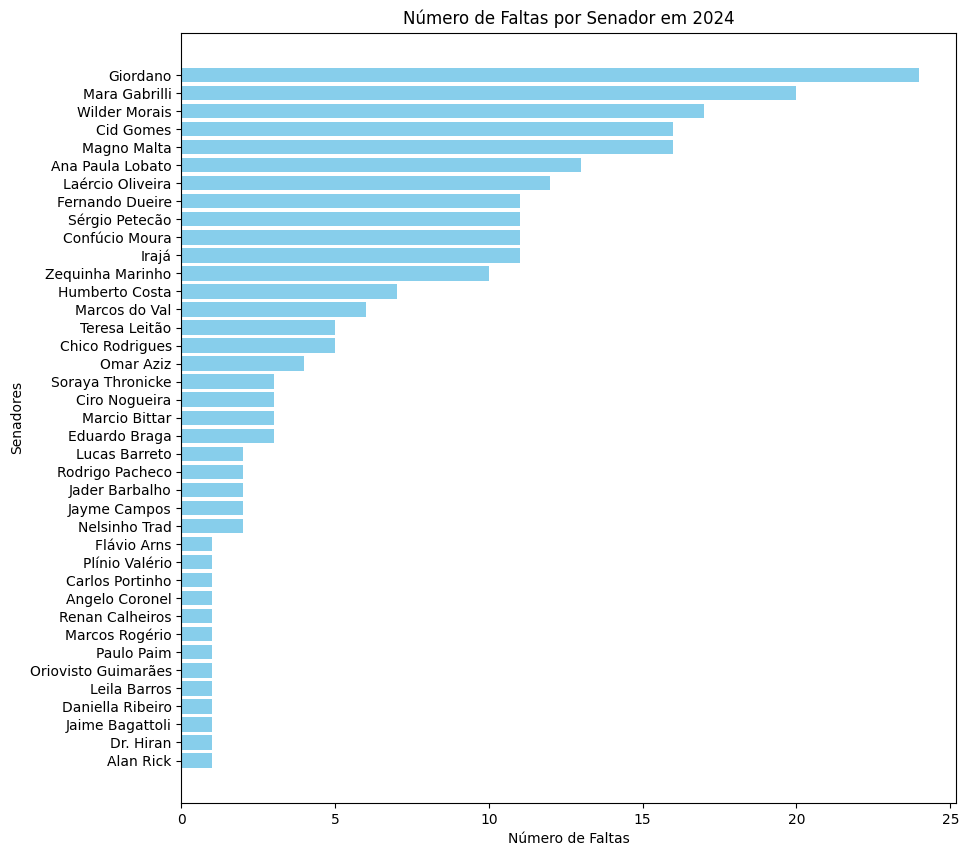

In [10]:
def obter_faltas_senador(codigo, ano=2024):
    url = f'https://legis.senado.leg.br/dadosabertos/senador/{codigo}/votacoes'
    params = {'ano': ano}
    
    response = requests.get(url, params=params, headers=headers)
    
    data = response.json()
    
    # inicializa a contagem de faltas
    faltas = 0
    
    votacoes = data.get('VotacaoParlamentar', {}).get('Parlamentar', {}).get('Votacoes', {}).get('Votacao', [])
    
    for votacao in votacoes:
        if votacao.get('DescricaoVoto') == 'Não Compareceu':
            faltas += 1
    
    return faltas

def calcular_faltas_senadores(df, ano=2024):
    df['Faltas'] = df['Código'].apply(lambda codigo: obter_faltas_senador(codigo, ano))
    # filtra apenas os senadores com faltas > 0
    df_faltas = df[df['Faltas'] > 0]
    return df_faltas[['Código', 'Nome', 'Faltas']].sort_values(by='Faltas', ascending=False)

def plotar_faltas_senadores(df_faltas):
    plt.figure(figsize=(10, 10))
    plt.barh(df_faltas['Nome'], df_faltas['Faltas'], color='skyblue')
    plt.xlabel('Número de Faltas')
    plt.ylabel('Senadores')
    plt.title('Número de Faltas por Senador em 2024')
    # inverte o eixo Y para poder ler o nome dos senadores com mais facilidade
    plt.gca().invert_yaxis()
    plt.show()


df_faltas = calcular_faltas_senadores(df_senadores_atuais)
plotar_faltas_senadores(df_faltas)

In [11]:
!pip freeze > requirements.txt